In [1]:
# Pandas
import pandas as pd

# Preprocessing 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

# Pipeline
from sklearn.pipeline import Pipeline   # Sequentially apply a list of transformations
from sklearn.compose import ColumnTransformer # Applies in parallel transformations to columns
from sklearn.preprocessing import FunctionTransformer 

# Grid search 
from sklearn.model_selection import GridSearchCV

from sklearn import set_config
set_config(display='diagram')

# The Titanic dataset - Who will survive?

In [2]:
titanic_data = pd.read_csv('data/titanic.csv')

**Numerical features**:
- Age
- Fare
- Pclass (passenger class)
- SibSp (number of siblings / spouses aboard the Titanic)
- Parch (number of parents / children aboard the Titanic)

**Categorical features**:
- Sex
- Ticket
- Cabin
- Embarked (Port of Embarkation: C, Q, and S)

In [3]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Feature Engineering

It is often valuable to create new features from the existing ones. This process is called feature engineering. In this notebook, we will create the following new features:
- Family Size
- Title

Creating a function to extract the title (Mr, Mrs, Miss, Dr, etc) from the name

In [4]:
titanic_data.Name.head(20)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

In [5]:
titanic_data.Name[0].split(",")[1].split('.')[0].strip()

'Mr'

Let's create a feature that extracts the title from the name (i.e. Mr, Mrs, Miss, Dr, etc)

In [7]:
# Title feature
titles = titanic_data.Name.apply(lambda x: x.split(",")[1].split(".")[0].strip())
titles

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Name, Length: 891, dtype: object

<Axes: xlabel='Name'>

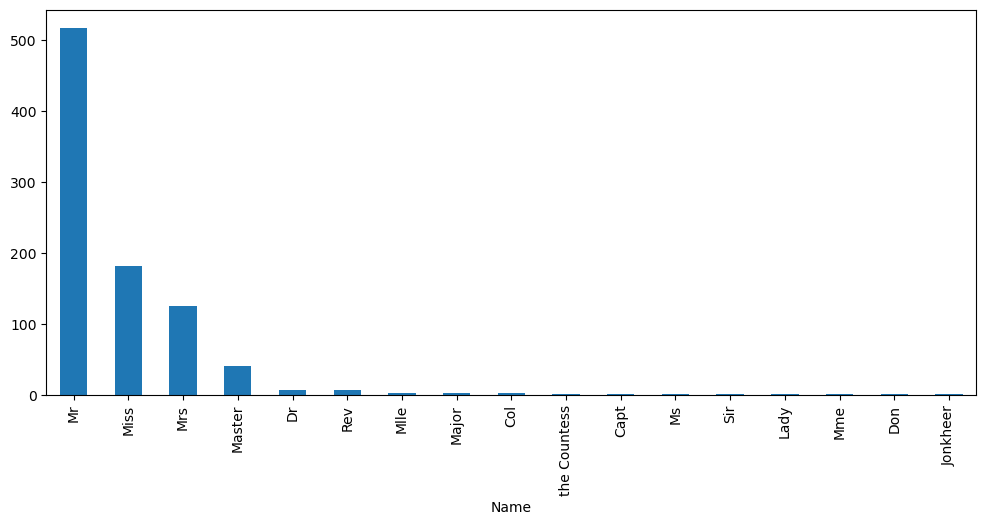

In [8]:
titles.value_counts().plot(kind='bar',figsize=(12,5))

Since there are many titles, we will group them into 4 categories: Mr, Miss, Mrs, Master, Dr., Rev, and convert the remaining titles to 'Other'.

In [9]:
# replace the less common titles with 'Other'
most_common_titles = titles.value_counts().head(6).index.to_list()
titles[~titles.isin(most_common_titles)] = 'Other'

<Axes: >

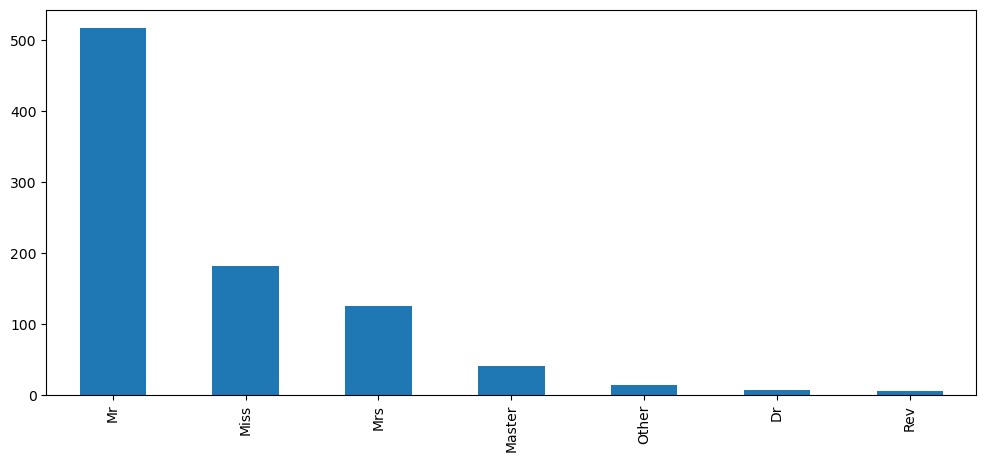

In [9]:
titles.value_counts().plot(kind='bar',figsize=(12,5))

Below I define a function to use in the pipeline during feature transformation.

In [10]:
def get_title(dataframe):
    '''
    Extract the title from the name column and replace the less common titles with 'Other'
    '''
    df = dataframe.copy()
    df['Title'] = df.Name.apply(lambda x: x.split(",")[1].split(".")[0].strip())
    df.loc[~df.Title.isin(most_common_titles),'Title'] = 'Other'
    return df

In [11]:
# check that it works
get_title(titanic_data)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr


I will now define a feature that computes the family size of a passenger. The family size is the sum of the number of siblings/spouses and the number of parents/children, plus one (the passenger themselves).

In [13]:
# family size
family_size = titanic_data.SibSp+titanic_data.Parch+1
family_size

0      2
1      2
2      1
3      2
4      1
      ..
886    1
887    1
888    4
889    1
890    1
Length: 891, dtype: int64

In [14]:
def get_family_size(dataframe):
    df = dataframe.copy()
    df['Family_size'] = df.SibSp + df.Parch + 1
    return df

In [15]:
# check that it works
get_family_size(titanic_data)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


Create a function transformer that will act as our processor in the pipeline.

In [16]:
# Functions for the pipeline
family_size_processor = FunctionTransformer(get_family_size)
title_processor = FunctionTransformer(get_title)

We will use them later in the pipeline.

### Scaling and Imputing

Using a series of pipelines and a column transformer, we can apply different transformations to different columns. In this case, we will scale the numerical features and impute missing values.

Imputing is the process of replacing missing values with a valid value. In this case, we will replace missing values with the median of the column.

In [17]:
# numerical features pipeline: impute+scale
numeric_features = ['Age', 'Fare','Family_size', 'Pclass']
numeric_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

Then impute and encode the categorical features.

In [18]:
# categorical_features pipeline: impute+encode
categorical_features = ['Embarked', 'Sex','Title']
categorical_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())])

The ColumnTransformer applies transformers to columns of an array or pandas DataFrame.  It will be used in the Pipeline.

In [19]:
feature_processor = ColumnTransformer(
    transformers=[
        ('num', numeric_processor, numeric_features),
        ('cat', categorical_processor, categorical_features)
    ],
         remainder='drop') # drop 'Name', 'SibSp', 'Parch' columns (they were not included in the numeric or categorical features and are used in the family_size feature)

In [20]:
def titanic_data_transformed(t_data):

    # Group ticket feature extraction
    group_tickets = t_data['Ticket'].value_counts() > 1
    t_data['Is_Group'] = t_data['Ticket'].apply(lambda x: 1 if group_tickets[x] else 0)
    t_data['Group_Size'] = t_data['Ticket'].map(t_data['Ticket'].value_counts())

    # Functions for title and family size extraction
    def get_title(data):
        titles = data['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
        common_titles = titles.value_counts().nlargest(6).index
        return titles.where(titles.isin(common_titles), 'Other')

    def get_family_size(data):
        return data['SibSp'] + data['Parch'] + 1

    # Transformation pipelines
    numerical_features = ['Age', 'Fare', 'FamilySize', 'Group_Size']
    numerical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_features = ['Sex', 'Embarked', 'Title', 'Pclass']
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Apply the custom transformations
    t_data['Title'] = get_title(t_data)
    t_data['FamilySize'] = get_family_size(t_data)

    # Column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    # Fit the transformer and transform the data
    transformed_data = preprocessor.fit_transform(t_data)

    # Getting the column names for numerical features
    numerical_cols = numerical_features

    # Getting the column names for categorical features
    categorical_cols = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)

    # Combine all column names
    all_cols = list(numerical_cols) + list(categorical_cols)

    # Add any remaining columns that were 'passed through'
    pass_through_cols = [col for col in t_data.columns if col not in numerical_features + categorical_features]
    all_cols.extend(pass_through_cols)

    # Create the DataFrame
    transformed_df = pd.DataFrame(transformed_data, columns=all_cols)

    transformed_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

    # Set all dtypes to float
    transformed_df = transformed_df.astype(float)

    return transformed_df

In [21]:
t_data_transformed = titanic_data_transformed(titanic_data)

### Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

In [23]:
# train test split
from sklearn.model_selection import train_test_split

# feature_cols = ['Name','Age','Fare','Sex','Embarked','Pclass','SibSp','Parch']
X = t_data_transformed.drop('Survived', axis=1)
y = t_data_transformed.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit the pipeline
rf_clf.fit(X_train, y_train)

# predict
y_pred = rf_clf.predict(X_test)

# evaluate
from sklearn.metrics import accuracy_score

print('Accuracy:', accuracy_score(y_test, y_pred))

# show how each feature contributes positively or negatively to the survival of the passengers
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf_clf, random_state=1).fit(X_test, y_test)
# show the weights for each feature, change the color scheme to blue
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=50)

Accuracy: 0.8324022346368715



Weight,Feature
0.0425 ± 0.0207,Fare
0.0324 ± 0.0164,Title_Mr
0.0223 ± 0.0173,Age
0.0145 ± 0.0305,Embarked_S
0.0134 ± 0.0152,Sex_male
0.0134 ± 0.0270,Pclass_1
0.0123 ± 0.0179,Sex_female
0.0045 ± 0.0084,Embarked_C
0.0022 ± 0.0055,Title_Master
0.0011 ± 0.0130,SibSp


The weights above are the feature importances. The higher the weight, the more important the feature is. Positive weights indicate that the feature is positively correlated with the target variable, while negative weights indicate that the feature is negatively correlated with the target variable. (i.e. the higher the feature, the less likely the passenger survived).

### Grid search for hyperparameter tuning

In [24]:
# feature matrix/ target vector
# Not using Ticket or Cabin since they are complex strings that are hard to encode
# Also not including PassengerId since it is just an identifier
feature_cols = ['Name','Age','Fare','Sex','Embarked','Pclass','SibSp','Parch']
X = titanic_data[feature_cols] 
y = titanic_data.Survived

In [25]:
# reload the data
titanic_data = pd.read_csv('data/titanic.csv')
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [26]:
pipe = Pipeline(steps=[('get family_size', family_size_processor),
                           ('get title', title_processor),
                           ('preprocessor', feature_processor),
                        #    ('poly_features', PolynomialFeatures(degree=2)),
                           ('clf',rf_clf)   
                          ])
pipe

Pipeline(steps=[('get family_size',
                 FunctionTransformer(func=<function get_family_size at 0x00000187C3322D40>)),
                ('get title',
                 FunctionTransformer(func=<function get_title at 0x00000187C3707060>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'Family_size',
                                                   'Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Embarked', 'Sex',
                                                   'Title'])])),
                ('clf', RandomForestClassifier())])

In [27]:
# train/test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [28]:
param_grid = { 
    'clf__n_estimators': list(range(100,400,50)),
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__max_depth' : [4,5,6,7,8],
    'clf__criterion' :['gini', 'entropy']
}

In [29]:
# instantiate and fit the grid
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('get family_size',
                                        FunctionTransformer(func=<function get_family_size at 0x00000187C3322D40>)),
                                       ('get title',
                                        FunctionTransformer(func=<function get_title at 0x00000187C3707060>)),
                                       ('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardSc...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Embarked',
                                                                          'Sex',
                                                                          'Title'])])),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [4, 5, 6, 7, 8],
                         'clf__max_features': ['auto', 'sqrt', 'log2'],
                         'clf__n_estimators': [100, 150, 200, 250, 300, 350]},
             scoring='accuracy', verbose=1)

In [30]:
# view the results
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'params']]

,mean_test_score,params
0,0.825805,"{'clf__criterion': 'gini', 'clf__max_depth': 4..."
1,0.828602,"{'clf__criterion': 'gini', 'clf__max_depth': 4..."
2,0.825785,"{'clf__criterion': 'gini', 'clf__max_depth': 4..."
3,0.828602,"{'clf__criterion': 'gini', 'clf__max_depth': 4..."
4,0.830001,"{'clf__criterion': 'gini', 'clf__max_depth': 4..."
...,...,...
175,0.825805,"{'clf__criterion': 'entropy', 'clf__max_depth'..."
176,0.822998,"{'clf__criterion': 'entropy', 'clf__max_depth'..."
177,0.821580,"{'clf__criterion': 'entropy', 'clf__max_depth'..."
178,0.822969,"{'clf__criterion': 'entropy', 'clf__max_depth'..."


In [31]:
# best hyper-parameters
grid.best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 6,
 'clf__max_features': 'log2',
 'clf__n_estimators': 350}

In [32]:
# best accuracy
grid.best_score_

0.8426770412685904

In [33]:
# best predictor
best_clf = grid.best_estimator_

In [34]:
# feature importances
importances = best_clf.named_steps['clf'].feature_importances_
columns = best_clf.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features)
columns = list(columns) + numeric_features
feature_importances = pd.DataFrame(importances, index=columns, columns=['importance'])
feature_importances.sort_values(by='importance',ascending=False)

,importance
Age,0.161620
Title_Miss,0.151071
Title_Mr,0.148656
Embarked_Q,0.129698
Sex_female,0.111950
Embarked_C,0.086440
Embarked_S,0.084921
Fare,0.044533
Title_Rev,0.022716
Title_Other,0.015856


### Test the model

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test_pred = best_clf.predict(X_test)
confusion_matrix(y_test,y_test_pred)
print(f'Accuracy: {accuracy_score(y_test,y_test_pred)}')

Accuracy: 0.8212290502793296


### A fake passenger

In [36]:
titanic_data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [49]:
# Making predictions: Would I have survived the Titanic disaster? 0 = No, 1 = Yes
Jake = pd.DataFrame({
                    'Name':['Bova, Mr. Jake','Bova, Dr. Jake'],
                    'Age': [28, 28],
                    'Fare': [10,500],
                    'Sex': ['male','male'],
                    'Embarked': ['S','C'],
                    'Pclass':[3,1],
                    'SibSp': [0,0],
                    'Parch': [0,0],
                   })
Jake

,Name,Age,Fare,Sex,Embarked,Pclass,SibSp,Parch
0,"Bova, Mr. Jake",28,10,male,S,3,0,0
1,"Bova, Dr. Jake",28,500,male,C,1,0,0


In [50]:
prediction = best_clf.predict(Jake)
# format the output, 0 = No, 1 = Yes
prediction = ['No' if pred == 0 else 'Yes' for pred in prediction]
prediction

['No', 'Yes']

The above results show that the model predicts that the passenger with title 'Mr' will not survive., but for title 'Dr' the model predicts that the passenger will survive.